# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer, accuracy_score
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [24]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2,
                    class_sep=.8, random_state=3, n_redundant=0)
]

In [25]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

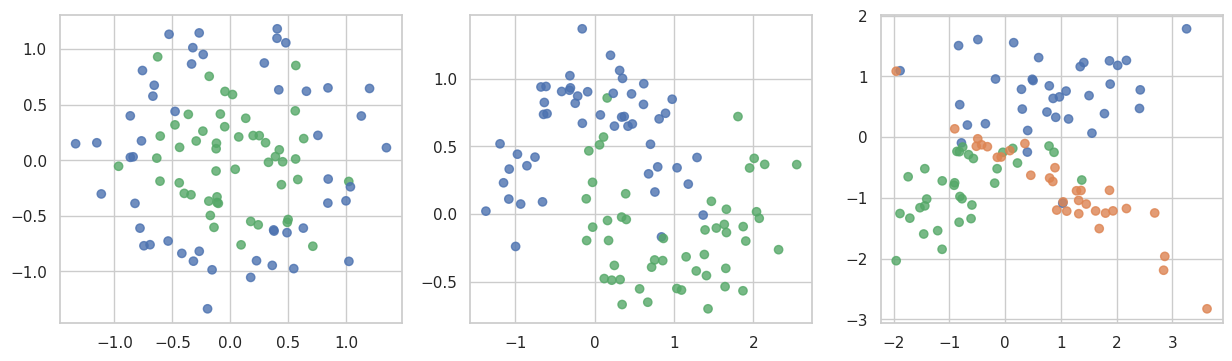

In [26]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [27]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)


Dataset: Circles
Train accuracy: 1.0
Test accuracy: 0.7333333333333333


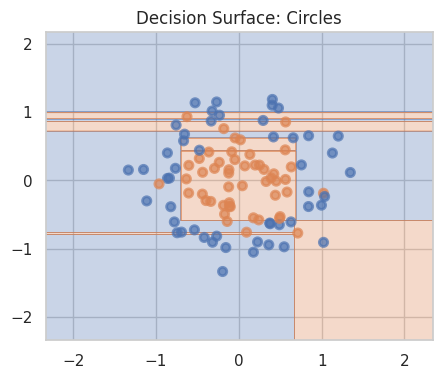


Dataset: Moons
Train accuracy: 1.0
Test accuracy: 0.8666666666666667


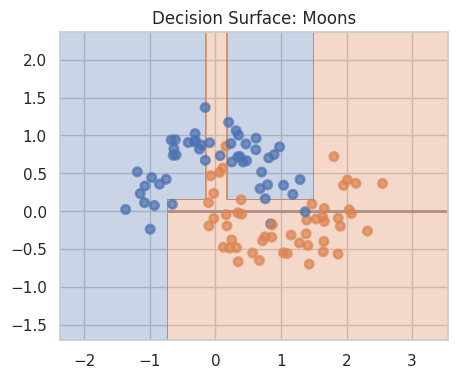


Dataset: Classification
Train accuracy: 1.0
Test accuracy: 0.8333333333333334


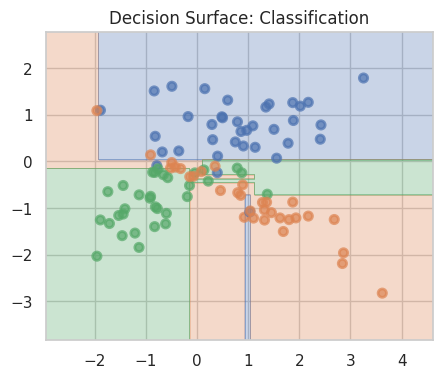

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluate_and_plot_tree(X, y, dataset_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    print(f"\nDataset: {dataset_name}")
    print("Train accuracy:", accuracy_score(y_train, clf.predict(X_train)))
    print("Test accuracy:", accuracy_score(y_test, clf.predict(X_test)))

    plt.figure(figsize=(5, 4))
    plot_surface(clf, X, y)
    plt.title(f"Decision Surface: {dataset_name}")
    plt.show()

for i, (X, y) in enumerate(datasets):
    name = ["Circles", "Moons", "Classification"][i]
    evaluate_and_plot_tree(X, y, name)


__Ответ:__
Обычно DecisionTreeClassifier сильно переобучается на train, особенно на сложных формах, таких как moons и circles.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?


Dataset: Circles


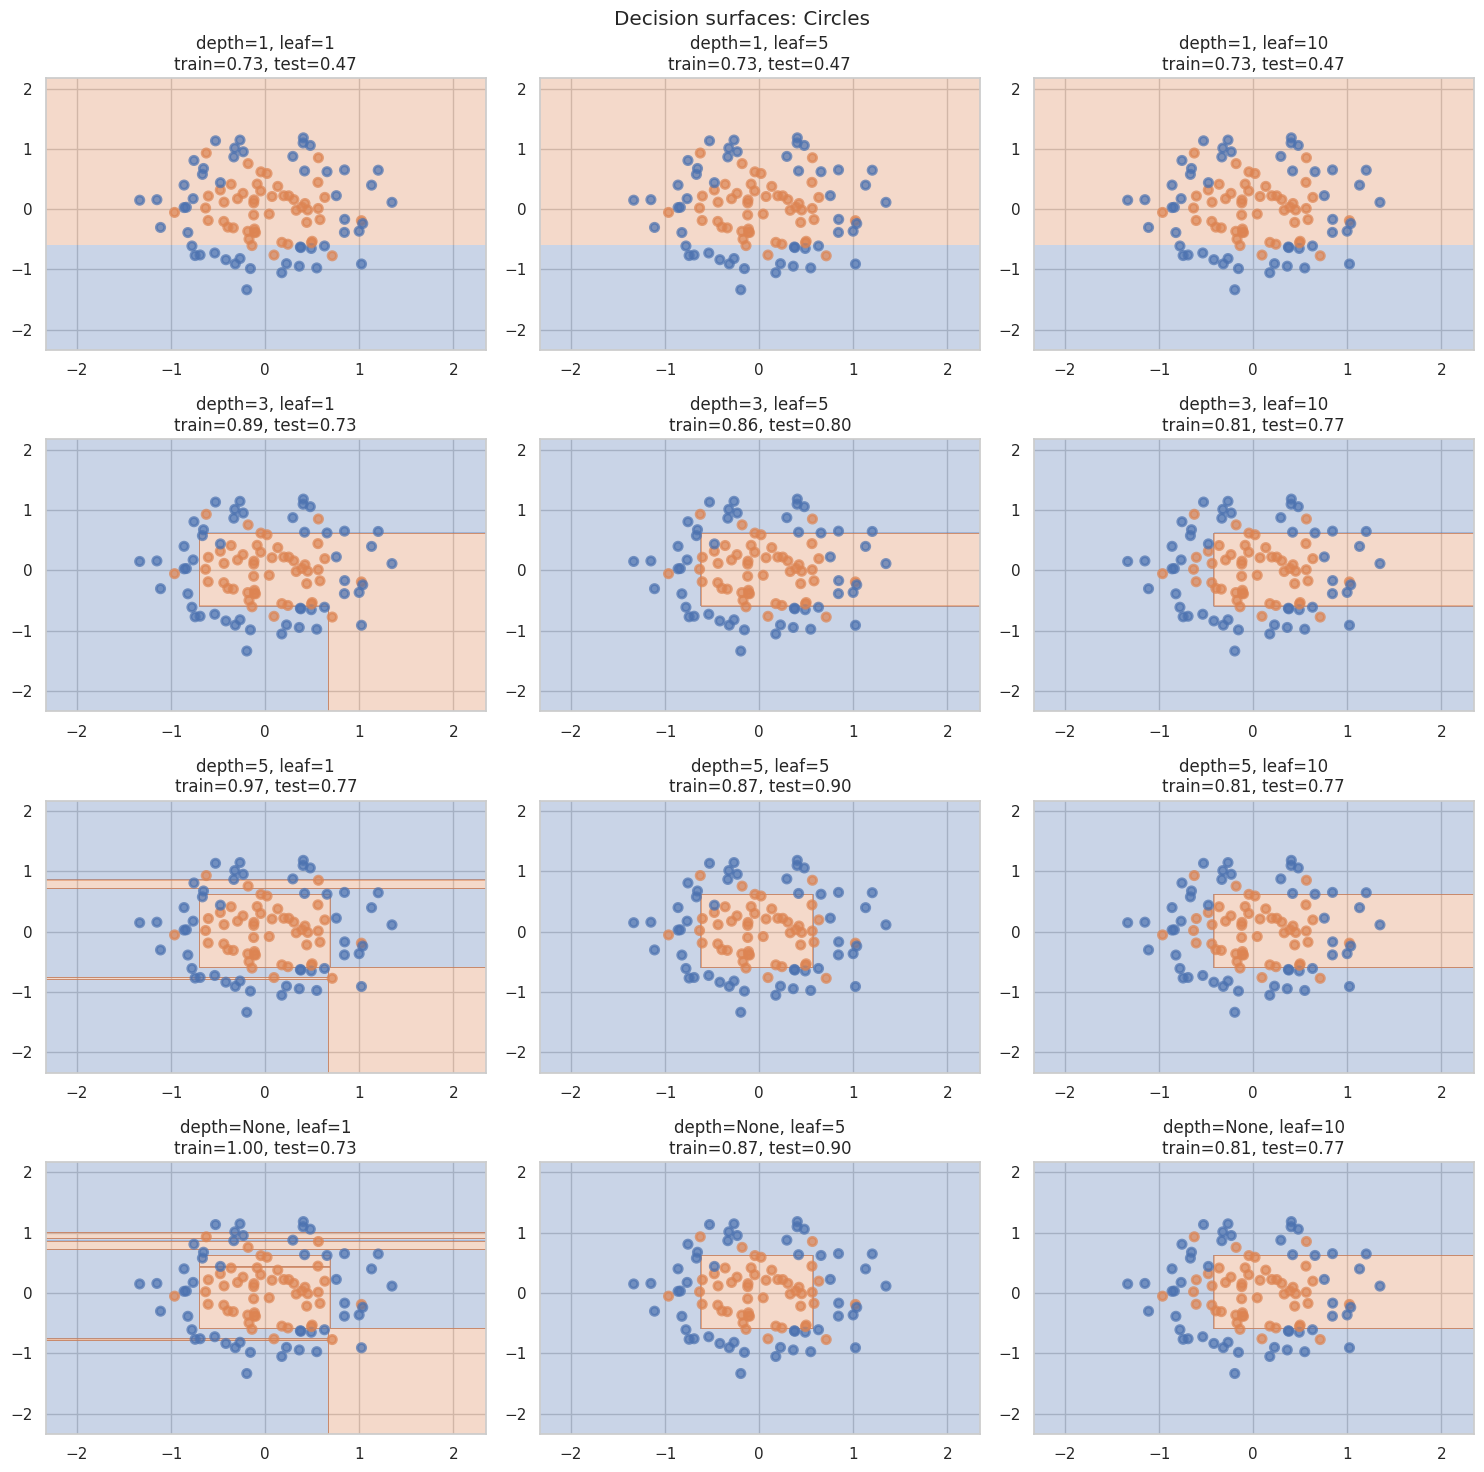


Dataset: Moons


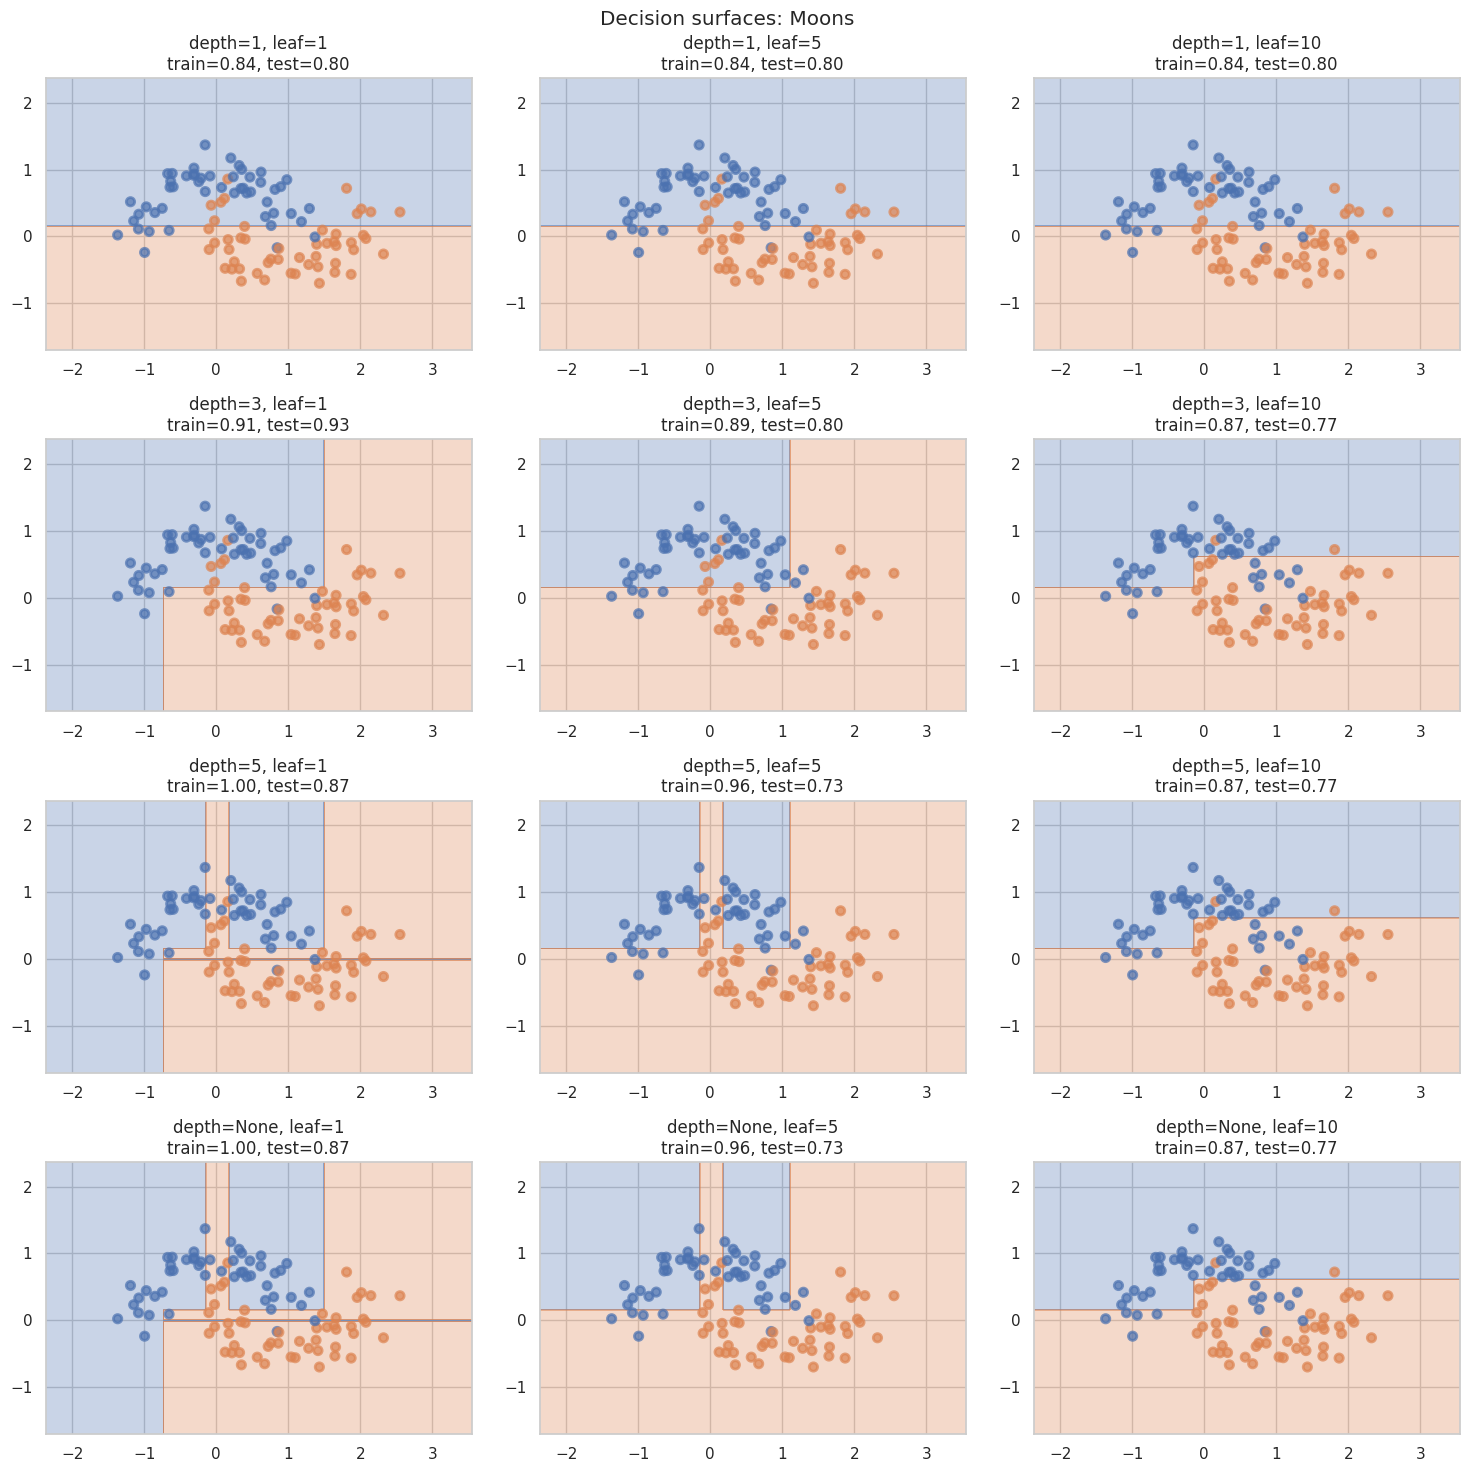


Dataset: Classification


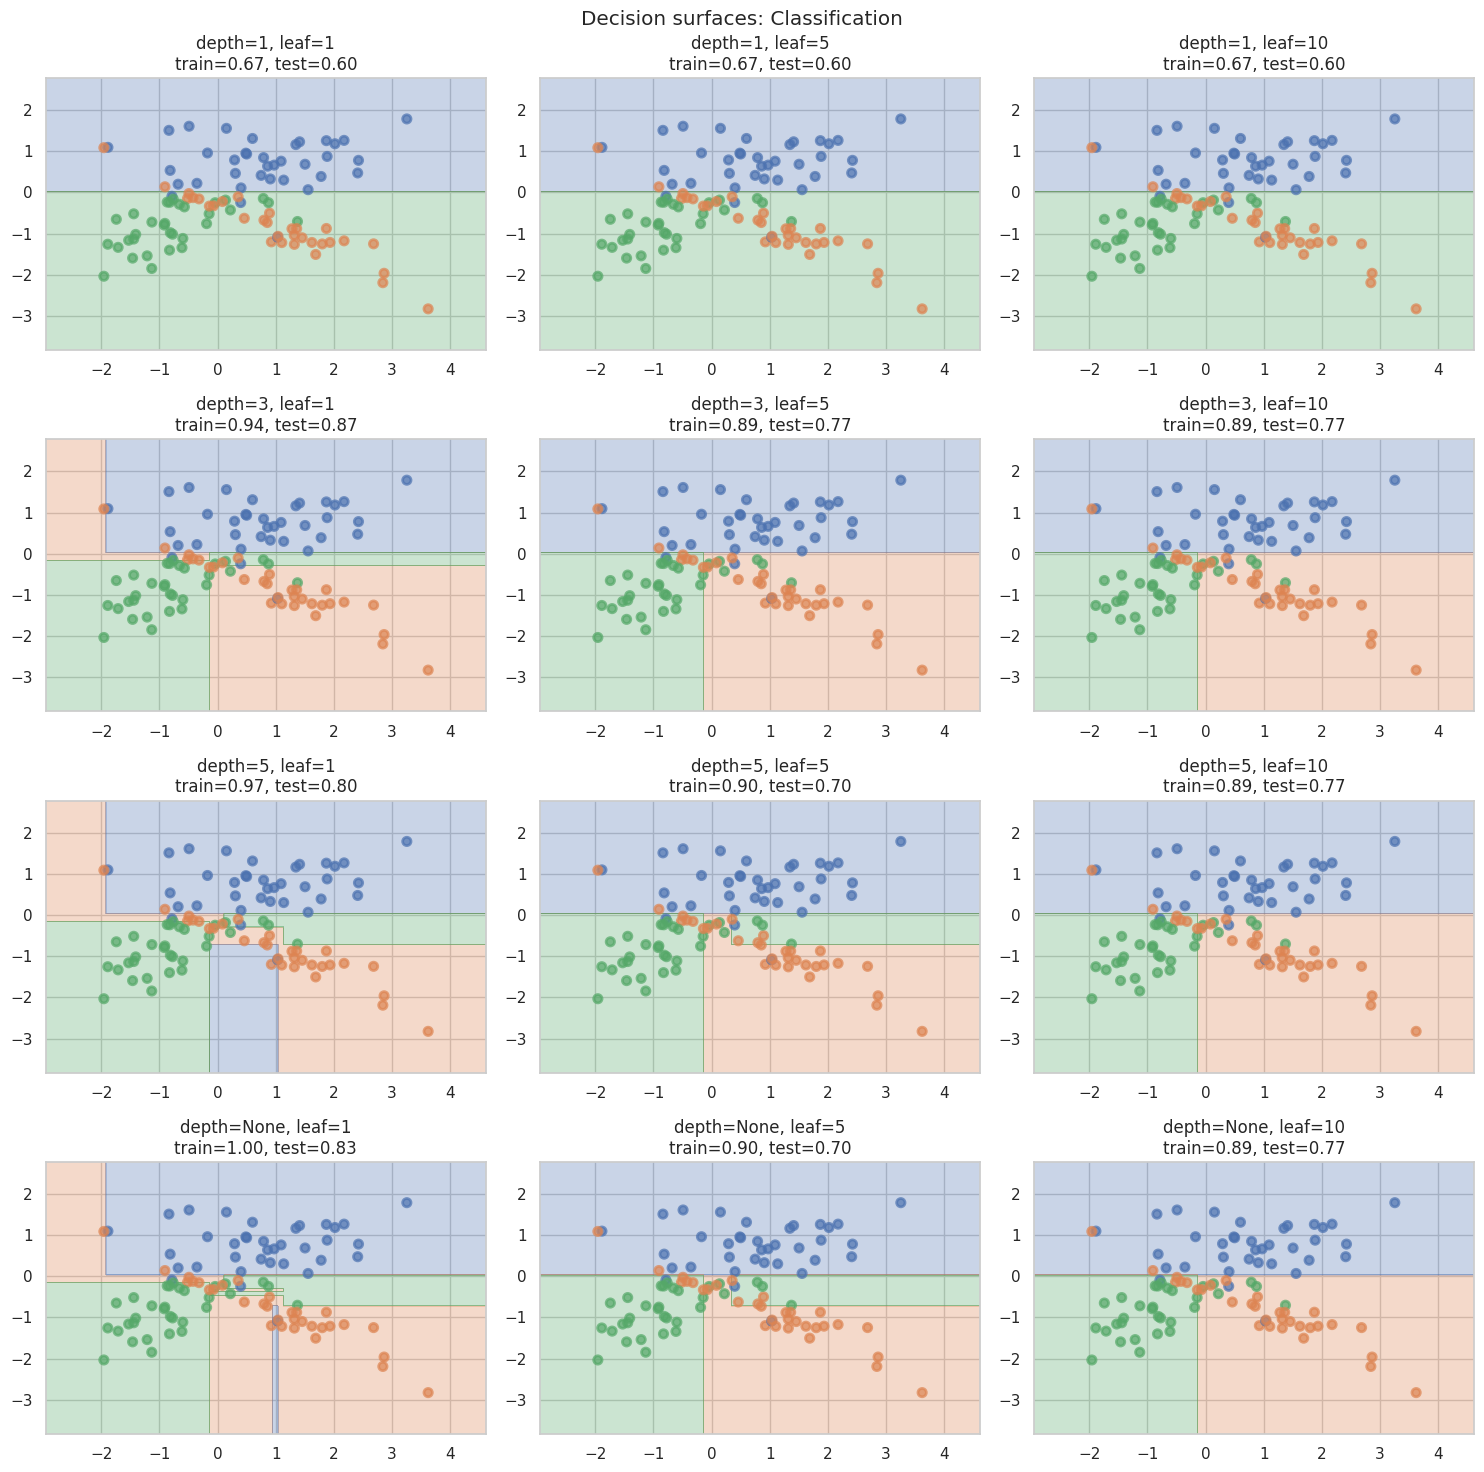

In [29]:
depths = [1, 3, 5, None]
min_leaves = [1, 5, 10]

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    name = ["Circles", "Moons", "Classification"][i]
    print(f"\nDataset: {name}")

    plt.figure(figsize=(15, 15))
    plot_num = 1
    for depth in depths:
        for leaf in min_leaves:
            clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
            clf.fit(X_train, y_train)
            train_acc = accuracy_score(y_train, clf.predict(X_train))
            test_acc = accuracy_score(y_test, clf.predict(X_test))

            plt.subplot(len(depths), len(min_leaves), plot_num)
            plot_surface(clf, X, y)
            plt.title(f"depth={depth}, leaf={leaf}\ntrain={train_acc:.2f}, test={test_acc:.2f}")
            plot_num += 1
    plt.suptitle(f"Decision surfaces: {name}")
    plt.tight_layout()
    plt.show()


__Ответ:__
Маленькая глубина даёт слишком грубую аппроксимацию. Увеличение глубины повышает train accuracy, но ухудшает обобщение на тесте. min_samples_leaf сглаживает модель, уменьшает переобучение. Поведение зависит от сложности формы данных.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

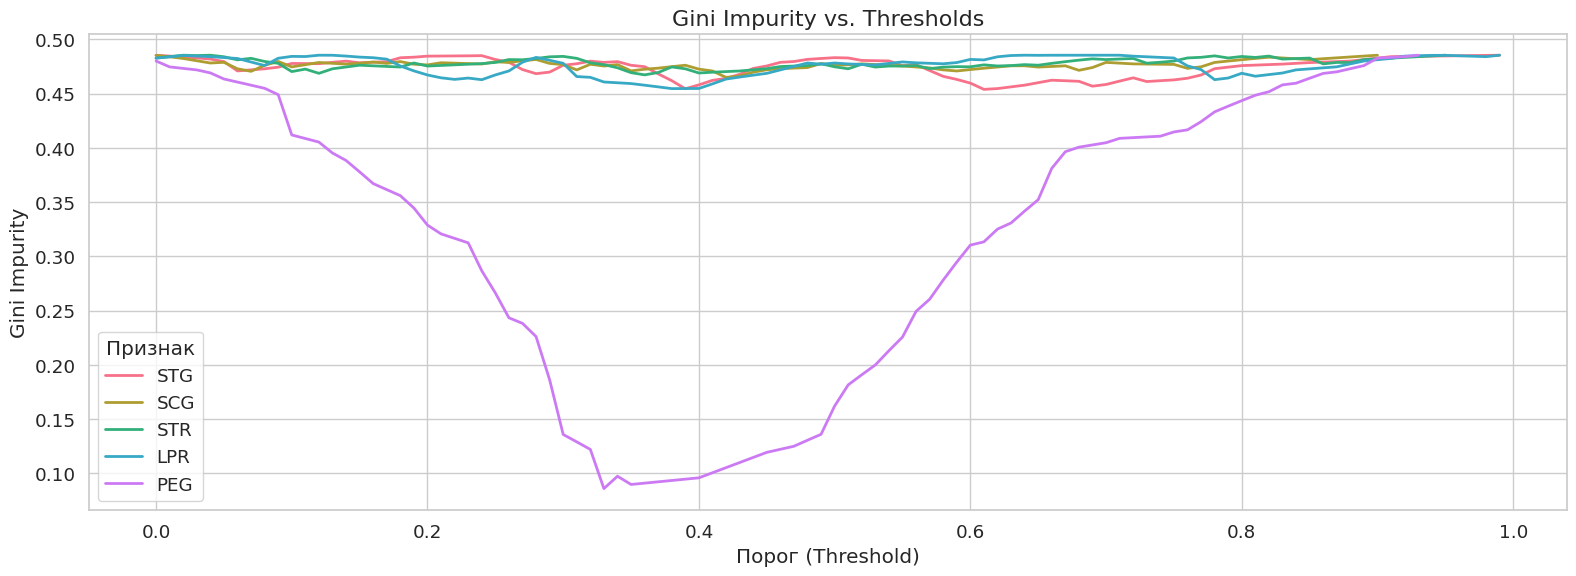

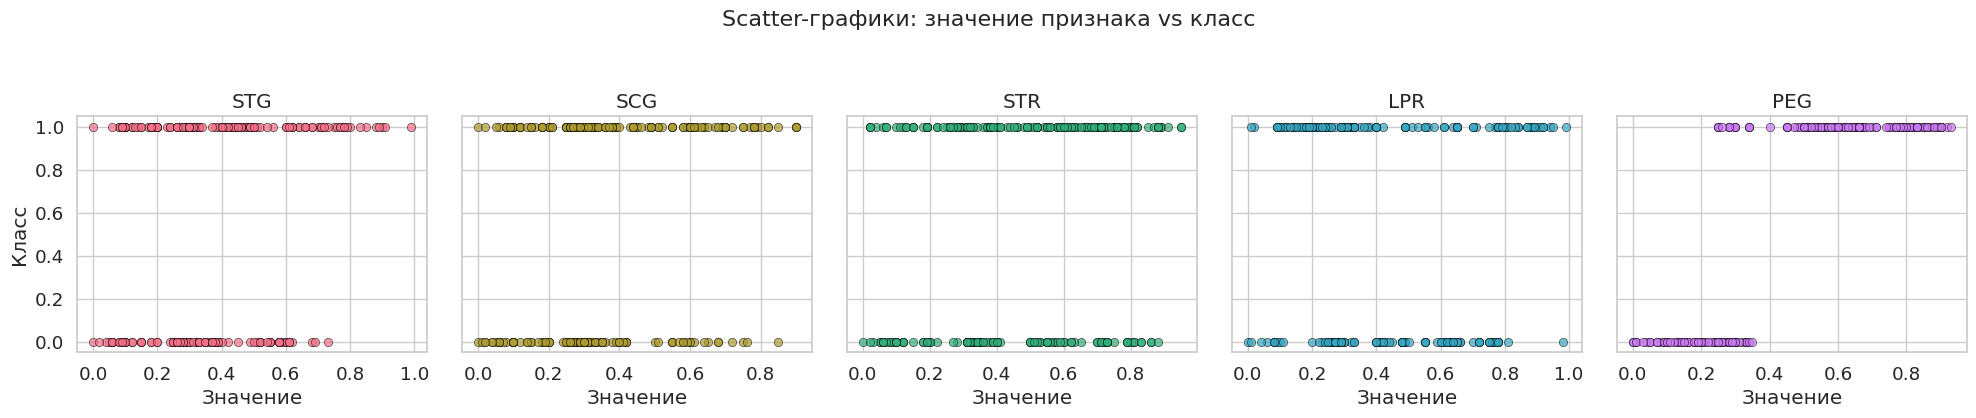

In [30]:
sns.set(style="whitegrid", font_scale=1.2)

df = pd.read_csv('data/students.csv')
feature_names = df.columns[:-1]
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

def gini_impurity(y):
    if len(y) == 0:
        return 0
    p = np.bincount(y) / len(y)
    return 1.0 - np.sum(p ** 2)

def gini_by_thresholds(x, y):
    thresholds = np.unique(x)
    gini_scores = []
    for t in thresholds:
        left = y[x <= t]
        right = y[x > t]
        w1 = len(left) / len(y)
        w2 = 1 - w1
        score = w1 * gini_impurity(left) + w2 * gini_impurity(right)
        gini_scores.append(score)
    return thresholds, gini_scores

plt.figure(figsize=(16, 6))
colors = sns.color_palette("husl", len(feature_names))
for i, name in enumerate(feature_names):
    x = X[:, i]
    thresholds, scores = gini_by_thresholds(x, y)
    plt.plot(thresholds, scores, label=name, color=colors[i], linewidth=2)
plt.title('Gini Impurity vs. Thresholds', fontsize=16)
plt.xlabel('Порог (Threshold)')
plt.ylabel('Gini Impurity')
plt.legend(title='Признак')
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, len(feature_names), figsize=(20, 4), sharey=True)
for i, name in enumerate(feature_names):
    sns.scatterplot(x=X[:, i], y=y, ax=axs[i], color=colors[i], alpha=0.7, edgecolor='black')
    axs[i].set_title(name)
    axs[i].set_xlabel('Значение')
    if i == 0:
        axs[i].set_ylabel('Класс')
plt.suptitle('Scatter-графики: значение признака vs класс', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()



__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
Признак, у которого Gini кривая имеет резкий минимум и глубокую «яму», — лучший кандидат, в нашем случае это PEG. Он чётко делит выборку. На scatter-графике у него классы отделимы. Плохие признаки дают почти плоскую кривую без выраженного минимума.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [31]:
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
    "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root",
    "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
    "spore-print-color", "population", "habitat"
]

df = pd.read_csv('data/agaricus-lepiota.data', names=columns)

In [32]:
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X, y = df.drop("class", axis=1).values, df["class"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)


In [33]:
from hw2code import DecisionTree

In [34]:
tree = DecisionTree(["categorical"] * X.shape[1])
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

display(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")

'Accuracy: 0.98572'

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [35]:
def load_data(filepath):
    df = pd.read_csv(filepath)
    X = df.drop('V10', axis=1).values
    y = (df['V10'] == 'positive').astype(int).values
    return X, y

def evaluate_parameter(X_train, X_test, y_train, y_test, feature_types,
                      param_name, param_range, figsize=(10, 6), color='royalblue'):

    accuracies = []

    for value in param_range:
        clf = DecisionTree(feature_types, **{param_name: value})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    plt.figure(figsize=figsize)
    plt.plot(param_range, accuracies,
             marker='o',
             markersize=8,
             linewidth=2,
             color=color,
             markerfacecolor='white',
             markeredgewidth=2)

    plt.title(f"Влияние параметра '{param_name}' на точность модели", pad=20, fontsize=14)
    plt.xlabel(param_name, fontsize=12, labelpad=10)
    plt.ylabel("Точность (Accuracy)", fontsize=12, labelpad=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(param_range)
    plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)

    for x, y in zip(param_range, accuracies):
        plt.text(x, y + 0.005, f"{y:.3f}",
                 ha='center',
                 va='bottom',
                 fontsize=10)

    plt.tight_layout()
    plt.show()

    return accuracies


Оценка параметра: max_depth


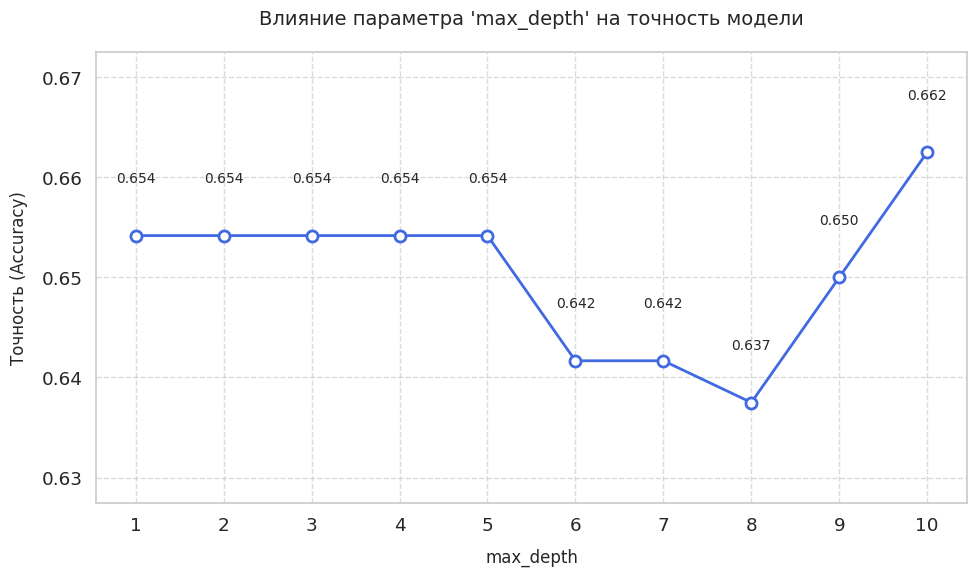

Лучшее значение: 10 с точностью 0.6625

Оценка параметра: min_samples_split


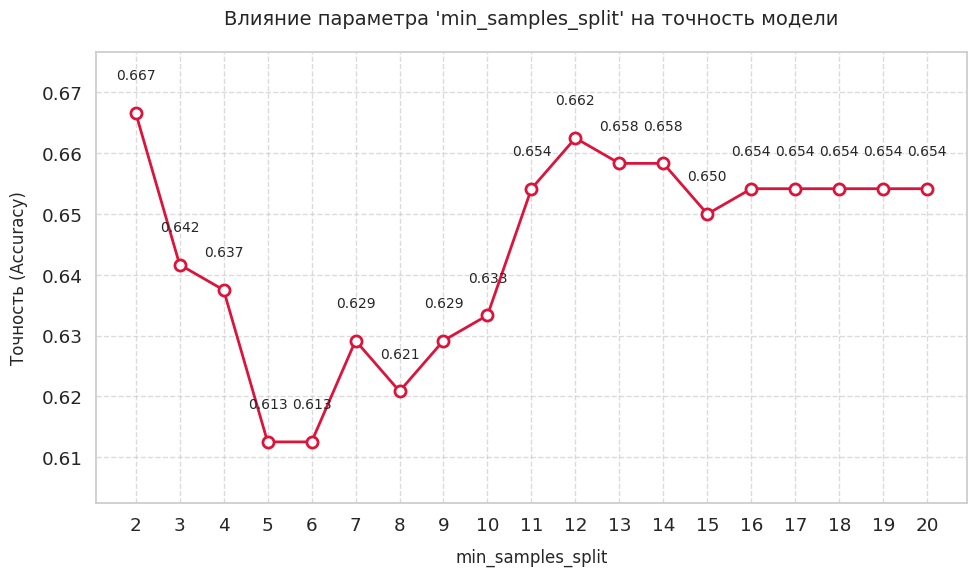

Лучшее значение: 2 с точностью 0.6667

Оценка параметра: min_samples_leaf


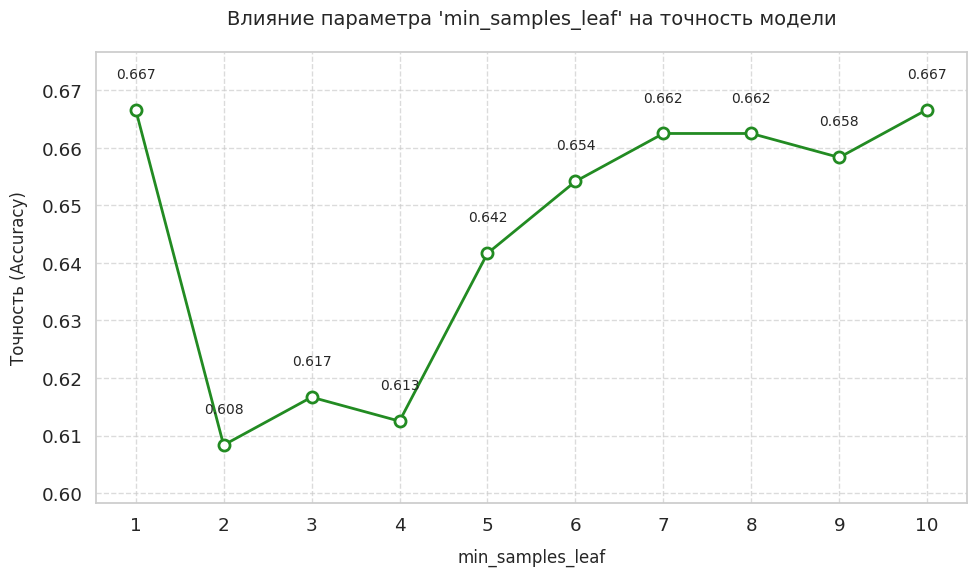

Лучшее значение: 1 с точностью 0.6667


In [36]:
X, y = load_data('data/tic-tac-toe-endgame.csv')
feature_types = ['categorical'] * X.shape[1]


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

params_to_evaluate = {
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 11)
}


colors = ['royalblue', 'crimson', 'forestgreen']

for (param_name, param_range), color in zip(params_to_evaluate.items(), colors):
    print(f"\nОценка параметра: {param_name}")
    accuracies = evaluate_parameter(
        X_train,
        X_test,
        y_train,
        y_test,
        feature_types=feature_types,
        param_name=param_name,
        param_range=param_range,
        color=color
    )

    best_idx = accuracies.index(max(accuracies))
    print(f"Лучшее значение: {param_range[best_idx]} с точностью {accuracies[best_idx]:.4f}")

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [37]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def load_and_preprocess(dataset_name, url):
    try:
        df = pd.read_csv(url, header=None)
    except Exception as e:
        raise ValueError(f"Ошибка загрузки данных из {url}: {str(e)}")

    preprocessing_rules = {
        'mushrooms': {
            'X_cols': slice(1, None),
            'y_mapping': {'e': 0, 'p': 1}
        },
        'tic_tac_toe': {
            'X_cols': slice(None, -1),
            'y_mapping': {'negative': 0, 'positive': 1}
        },
        'cars': {
            'X_cols': slice(None, -1),
            'y_mapping': {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
        },
        'nursery': {
            'X_cols': slice(None, -1),
            'y_mapping': {
                'not_recom': 0,
                'recommend': 0,
                'very_recom': 1,
                'priority': 1,
                'spec_prior': 1
            }
        }
    }

    if dataset_name not in preprocessing_rules:
        supported_datasets = ", ".join(preprocessing_rules.keys())
        raise ValueError(f"Неподдерживаемый набор данных '{dataset_name}'. Доступные варианты: {supported_datasets}")

    rules = preprocessing_rules[dataset_name]

    X = df.iloc[:, rules['X_cols']]
    y = df.iloc[:, -1].replace(rules['y_mapping'])

    X_encoded = X.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)))

    if not np.issubdtype(y.dtype, np.number):
        y_encoded = LabelEncoder().fit_transform(y.astype(str))
    else:
        y_encoded = y.values

    return X_encoded, y_encoded

In [38]:
class SklearnCompatibleTree(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types):
        self.feature_types = feature_types
        self.model = DecisionTree(feature_types=feature_types)

    def fit(self, X, y):
        self.model.fit(np.array(X), np.array(y))
        return self

    def predict(self, X):
        return self.model.predict(np.array(X))

In [39]:
datasets = {
    "mushrooms": "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    "tic_tac_toe": "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
    "cars": "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
    "nursery": "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
}
results = {}

In [40]:
for name, url in datasets.items():
    X, y = load_and_preprocess(name, url)

    # 1. Реальные признаки
    tree_real = SklearnCompatibleTree(["real"] * X.shape[1])
    acc_real = cross_val_score(tree_real, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    # 2. Категориальные признаки
    tree_cat = SklearnCompatibleTree(["categorical"] * X.shape[1])
    acc_cat = cross_val_score(tree_cat, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    # 3. One-hot + вещественные признаки
    ohe = OneHotEncoder(sparse_output=False)
    X_ohe = ohe.fit_transform(X)
    tree_ohe = SklearnCompatibleTree(["real"] * X_ohe.shape[1])
    acc_ohe = cross_val_score(tree_ohe, X_ohe, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    # 4. sklearn
    sk_tree = DecisionTreeClassifier()
    acc_sk = cross_val_score(sk_tree, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    # Запись результатов
    results[name] = [acc_real, acc_cat, acc_ohe, acc_sk]

# В таблицу
df_results = pd.DataFrame(results, index=[
    "custom_real", "custom_categorical", "custom_ohe", "sklearn_tree"
]).T

display(df_results)


,custom_real,custom_categorical,custom_ohe,sklearn_tree
mushrooms,0.733686,0.795741,0.801520,0.988192
tic_tac_toe,0.402226,0.495077,0.386634,0.790450
cars,0.914777,0.954208,0.919368,0.943285
nursery,0.999846,0.999846,0.999846,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**
   - Набор данных `nursery` показывает почти идеальную точность для всех методов (99.9%), что говорит о его простоте для деревьев.
   - Набор `mushrooms` и `cars` также хорошо классифицируются (73-98% и 91-95% соответственно).
   - Набор `tic_tac_toe` оказался самым сложным (38-79% точности).

2. **Ранжирование методов**:
   - **Sklearn DecisionTree** показал наилучшие результаты на всех наборах данных, кроме `nursery`, где все методы сравнялись.
   - **Кастомные деревья**:
     - Категориальный подход (`custom_categorical`) часто превосходил вещественный (`custom_real`), особенно на `mushrooms` (79.6% vs 73.4%) и `cars` (95.4% vs 91.5%).
     - One-hot encoding (`custom_ohe`) показал неоднозначные результаты: выиграл на `mushrooms`, но проиграл на `tic_tac_toe`.

3. **Причины различий**:
   - **Sklearn vs кастомные**:
     - Sklearn имеет более сложную оптимизацию (например, улучшенный критерий остановки, обработку пропусков).
     - Возможны различия в реализации split-алгоритмов.
   - **Категориальные vs вещественные**:
     - Категориальные признаки лучше работают, когда данные действительно категориальные (как в `mushrooms` и `cars`).
     - One-hot может ухудшать качество из-за "размытия" информации по многим фичам (особенно заметно на `tic_tac_toe`).

4. **Компонента случайности**:
   - На `tic_tac_toe` разброс результатов максимален (38-79%), что говорит о высокой чувствительности к кодированию признаков.
   - Можно улучшить:
     - Подбором гиперпараметров (глубина дерева, min_samples_split и др.).
     - Использованием более сложных методов кодирования (target encoding для категориальных).
     - Ансамблями деревьев (Random Forest, Gradient Boosting).


Вставьте что угодно, описывающее ваши впечатления от этого задания: